<a href="https://colab.research.google.com/github/MerkulovDaniil/split-sgd/blob/master/Code/Continuous_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear regression

In [0]:
# ======= Libraries =======

import math
import sys
import os
import time
os.environ["OMP_NUM_THREADS"] = "5" # export OMP_NUM_THREADS=5
os.environ["OPENBLAS_NUM_THREADS"] = "5" # export OPENBLAS_NUM_THREADS=5
os.environ["MKL_NUM_THREADS"] = "5" # export MKL_NUM_THREADS=5
os.environ["VECLIB_MAXIMUM_THREADS"] = "5" # export VECLIB_MAXIMUM_THREADS=5
os.environ["NUMEXPR_NUM_THREADS"] = "5" # export NUMEXPR_NUM_THREADS=5
import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torchvision.datasets as datasets
from scipy.integrate import odeint, solve_ivp
# from torchdiffeq import odeint
from scipy.linalg import expm, qr
import scipy.io as sio
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import log_loss
import copy
from tqdm import tqdm
# if torch.cuda.is_available():
#     device = torch.device('cuda')
# else:
device = torch.device('cpu')
import copy
from fastprogress.fastprogress import master_bar, progress_bar
import random
# Reproducibility
random.seed(999)
np.random.seed(999)
torch.manual_seed(999)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [0]:
# ======= Function definitions =======

def load_tom_data(epsilon=1e-5):
    X = sio.loadmat("./lls_data/fanlinear.mat")["A"].toarray()
    theta_true = sio.loadmat("./lls_data/shepplogan.mat")["x"]
    n, p = X.shape
    y = np.squeeze(X @ theta_true)
    return X, theta_true, y

def generate_problem(p, n, lstsq=False, epsilon = 0):
    X = np.random.randn(n, p)

    # Model definition
    theta_clean = np.ones(p)
    y = X @ theta_clean + epsilon*np.random.randn(n) # right-hand side
    init_bound = 1.0/math.sqrt(p)
    theta_0 = np.array(init_bound*torch.FloatTensor(p).uniform_(-1, 1))

    if lstsq == True:
        theta_lstsq = np.linalg.lstsq(X,y)[0]
        return X, theta_0, y, theta_lstsq
    else:
        return X, theta_0, y

def solve_local_problem(Q, R, theta_0, y_batch, h, n):
    try:
        R_it = np.linalg.inv(R.T)
    except np.linalg.LinAlgError as err:
        # print(err)
        R_it = np.linalg.pinv(R.T)
    exp_m = expm(-1/n* R @ R.T*h)
    return Q @ ( exp_m @ (Q.T @ theta_0 - R_it @ y_batch )) + Q @ (R_it @ y_batch) + theta_0 - Q @ (Q.T @ theta_0)

def solve_local_problem_b_1(x, theta_0, y, h, n):
    x = x.T
    norm = x.T @ x
    return theta_0 + (1 - np.exp(-norm*h/n))*(y - x.T @ theta_0)/norm*x

def loss(X, theta, y):
    '''
    Supports batch reformulation. The difference in dimension of the input
    '''
    if len(X.shape) == 2:
        n, p = X.shape
        return 1/n*np.linalg.norm(X @ theta - y)**2
    elif len(X.shape) == 3:
        m, b, p = Xs.shape
        n = b*m

        loss = 0
        for i_batch in range(m):
            loss += 1/n*np.linalg.norm(X[i_batch] @ theta - y[i_batch])**2
        return loss
    else:
        raise ValueError('🤔 Inappropriate format of dataset')

def rel_residual(X, theta, y):
    '''
    Supports batch reformulation. The difference in dimension of the input
    '''
    if len(X.shape) == 2:
        n, p = X.shape
        return np.linalg.norm(X @ theta - y)/np.linalg.norm(y)
    elif len(X.shape) == 3:
        m, b, p = Xs.shape
        n = b*m

        loss = 0
        y_full = np.zeros(n)
        X_full = np.zeros((n, p))
        for i_batch in range(m):
            y_full[b*i_batch:b*(i_batch+1)]     = y[i_batch]
            X_full[b*i_batch:b*(i_batch+1), :]  = X[i_batch]

        return np.linalg.norm(X_full @ theta - y_full)/np.linalg.norm(y_full)
    else:
        raise ValueError('🤔 Inappropriate format of dataset')


def gradient(X, theta, y):
    '''
    Supports batch reformulation. The difference in dimension of the input
    '''
    if len(X.shape) == 2:
        n, p = X.shape
        return 1/n* X.T @ (X @ theta - y)
    elif len(X.shape) == 3:
        m, b, p = Xs.shape
        n = b*m

        gradient = 0
        for i_batch in range(m):
            gradient += 1/n* X[i_batch].T @ (X[i_batch] @ theta - y[i_batch])
        return gradient
    else:
        raise ValueError('🤔 Inappropriate format of dataset')

def make_SGD_step(X_batch, theta_0, y_batch, lr):
    theta = theta_0 - lr*gradient(X_batch, theta_0, y_batch)
    return theta

def sgd_training(theta_0, theta_lstsq, Xs, ys, lr, N_epochs = N_epochs):
    m, b, p = Xs.shape
    n = b*m
    loss_sgd, grad_sgd, par_diff_sgd = [], [], []
    theta_t = theta_0
    for i_epoch in range(N_epochs):
        loss_sgd.append(loss(Xs, theta_t, ys))
        grad_sgd.append(np.linalg.norm(gradient(Xs, theta_t, ys)))
        par_diff_sgd.append(np.linalg.norm(theta_t - theta_lstsq)/np.linalg.norm(theta_lstsq))
        for i_batch in range(m):          
            theta_t = make_SGD_step(Xs[i_batch], theta_t, ys[i_batch], lr)

        sys.stdout.write('\r'+f'🤖 SGD. Loss {loss_sgd[-1]:.3f}, Grad_norm {grad_sgd[-1]:.3f}, relpardiff {par_diff_sgd[-1]:.3f} after {i_epoch} epoch. Lr {lr}')

    print('\r'+f'🤖 SGD. Loss {loss_sgd[-1]:.3f}, Grad_norm {grad_sgd[-1]:.3f}, relpardiff {par_diff_sgd[-1]:.3f} after {i_epoch} epoch. Lr {lr}')    
    return loss_sgd, grad_sgd, par_diff_sgd

def gd_training(theta_0, theta_lstsq, X, y, total_time, stepsize):
    n, p = X.shape
    loss_gd, grad_gd, par_diff_gd = [], [], []
    theta_t = theta_0
    N_steps = int(total_time/stepsize)
    for i_step in range(N_steps):
        loss_gd.append(loss(X, theta_t, y))
        grad_gd.append(np.linalg.norm(gradient(X, theta_t, y)))
        par_diff_gd.append(np.linalg.norm(theta_t - theta_lstsq)/np.linalg.norm(theta_lstsq))
                  
        theta_t = theta_t - stepsize*gradient(X, theta_t, y)

        sys.stdout.write('\r'+f'🤖 GD. Loss {loss_gd[-1]:.3f}, Grad_norm {grad_gd[-1]:.3f}, relpardiff {par_diff_gd[-1]:.3f} after {i_step} step.')

    print('\r'+f'🤖 GD. Loss {loss_gd[-1]:.3f}, _gd_norm {grad_gd[-1]:.3f}, relpardiff {par_diff_gd[-1]:.3f} after {i_step} step.')    
    return loss_gd, grad_gd, par_diff_gd

def spl_training(theta_0, theta_lstsq, Qs, Rs, Xs, ys, stepsize, N_spl_steps = N_spl_steps):
    m, b, p = Xs.shape
    n = b*m
    loss_spl, grad_spl, par_diff_spl = [], [], []
    theta_t = theta_0
    for i_step in range(N_spl_steps):         
        i_batch = i_step % m
        if i_batch == 0:
            loss_spl.append(loss(Xs, theta_t, ys))
            grad_spl.append(np.linalg.norm(gradient(Xs, theta_t, ys)))
            par_diff_spl.append(np.linalg.norm(theta_t - theta_lstsq)/np.linalg.norm(theta_lstsq))
            sys.stdout.write('\r'+f'🤖 Splitting I. Loss {loss_spl[-1]:.3f}, Grad_norm {grad_spl[-1]:.3f}, relpardiff {par_diff_spl[-1]:.3f} after {i_step} epoch. Stepsize {stepsize}')

        theta_t = solve_local_problem(Qs[i_batch], Rs[i_batch], theta_t, ys[i_batch], stepsize, n)
    
    print('\r'+f'🤖 Splitting I. Loss {loss_spl[-1]:.3f}, Grad_norm {grad_spl[-1]:.3f}, relpardiff {par_diff_spl[-1]:.3f} after {i_step} steps. Stepsize {stepsize}')
    return loss_spl, grad_spl, par_diff_spl

def plot_continuous_time_lls(times, losses, grads, rel_diffs, labels, N_epochs, title = 'Linear least squares. Random'):
    colors = ['r', 'g', 'b']
    color_labels = ['^', 'o', '-']
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (9,3))
    fig.suptitle(title)
    for time, loss, grad, rel_diff, label, col, col_lab in zip(times, losses, grads, rel_diffs, labels, colors, color_labels):
        ax1.semilogy(time, loss,     col+col_lab, label = label)
        ax1.semilogy(time, loss,     col+':')
        ax2.semilogy(time, grad,     col+col_lab, label = label)
        ax2.semilogy(time, grad,     col+':')
        ax3.semilogy(time, rel_diff, col+col_lab, label = label)
        ax3.semilogy(time, rel_diff, col+':')
    ax1.grid(True,which="both", linestyle='--', linewidth=0.4)
    ax1.set_title(r'$f(\theta(t))$')
    ax1.set_xlabel('t')
    ax2.grid(True,which="both", linestyle='--', linewidth=0.4)
    ax2.set_title(r'$\|\nabla f(\theta(t))\|$')
    ax2.set_xlabel('t')
    ax3.grid(True,which="both", linestyle='--', linewidth=0.4)
    ax3.set_title(r'$\frac{\|\theta(t) - \theta_{LS}\|}{\|\theta_{LS}\|}$')
    ax3.set_xlabel('t')
    plt.legend()
    fig.tight_layout()
    # plt.savefig(title + '.pdf')
    plt.show()

In [0]:
# ======= Problem generation =======

# We fix best learning rate for the SGD and try different hs for the splitting. 
# Drawing 3 graphs in cont time (loss, grad_norm, norm of theparameter difference)

p = 400
n = 2000
m = 100
b = 20
epsilon = 1e-1

LEARNING_RATE = 10**(-1.5)
N_epochs = 10
h = LEARNING_RATE*m # with this values we have equal number of epochs
# h = 10
TOTAL_TIME = N_epochs*LEARNING_RATE*m
GF_STEPSIZE   = 1e-4

N_spl_epochs = int(np.floor(TOTAL_TIME/h))
N_spl_steps  = N_spl_epochs*m

LABELS = ['SGD', 'Splitting I']
ts_sgd = np.linspace(0, TOTAL_TIME, int(N_epochs))
ts_spl = np.linspace(0, N_spl_epochs*h, N_spl_epochs)
ts_gd  = np.linspace(0, TOTAL_TIME, int(TOTAL_TIME/GF_STEPSIZE))

# problems = ['tomography', 'random']
# problems = ['tomography']
problems = ['random']

X, theta_0, y, theta_lstsq = generate_problem(p, n, lstsq=True, epsilon = epsilon)
Xs = np.zeros((m, b, p))
ys = np.zeros((m, b))
Qs = np.zeros((m, p, b))
Rs = np.zeros((m, b, b))
Q, R = qr(X.T, mode='economic')

for i_batch in range(m):
    Xs[i_batch] = X[b*i_batch:b*(i_batch+1), :]
    ys[i_batch] = y[b*i_batch:b*(i_batch+1)]
    Qs[i_batch], Rs[i_batch] = qr(Xs[i_batch].T, mode='economic')

loss_sgd, grad_sgd, par_diff_sgd = sgd_training(theta_0, theta_lstsq, Xs, ys, lr = LEARNING_RATE, N_epochs = N_epochs)
loss_spl, grad_spl, par_diff_spl = spl_training(theta_0, theta_lstsq, Qs, Rs, Xs, ys, stepsize = h, N_spl_steps = N_spl_steps)
loss_gd, grad_gd, par_diff_gd    = gd_training(theta_0,  theta_lstsq, X, y, total_time = TOTAL_TIME, stepsize = GF_STEPSIZE)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


🤖 SGD. Loss 0.011, Grad_norm 0.062, relpardiff 0.003 after 9 epoch. Lr 0.03162277660168379
🤖 Splitting I. Loss 0.009, Grad_norm 0.045, relpardiff 0.002 after 999 steps. Stepsize 3.162277660168379
🤖 GD. Loss 2.849, Grad_norm 1.229, relpardiff 0.121 after 32398 step.

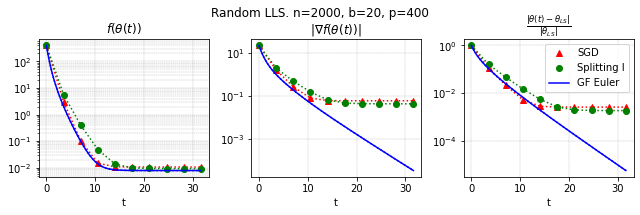

In [104]:
times     = [ts_sgd, ts_spl, ts_gd]
losses    = [loss_sgd, loss_spl, loss_gd]
grads     = [grad_sgd, grad_spl, grad_gd]
rel_diffs = [par_diff_sgd, par_diff_spl, par_diff_gd]
labels    = ['SGD', 'Splitting I', 'GF Euler']
title     = f'Random LLS. n={n}, b={b}, p={p}'
plot_continuous_time_lls(times, losses, grads, rel_diffs, labels, N_epochs, title)

# Logistic regression

In [0]:
# ======= Problem generation =======

TARGET_ERROR    = 0.001
N_EXPERIMENTS   = 30
LEARNING_RATES  = np.array(np.logspace(-3, 2, 10))
LEARNING_RATES  = np.append(LEARNING_RATES, np.array(np.logspace(2, 7, 6)))
iter_limit      = 30000

GD_N_iter     = np.zeros((N_EXPERIMENTS, len(LEARNING_RATES)))
SGD_N_iter    = np.zeros((N_EXPERIMENTS, len(LEARNING_RATES)))
SPL_N_iter    = np.zeros((N_EXPERIMENTS, len(LEARNING_RATES)))

GD_time     = np.zeros((N_EXPERIMENTS, len(LEARNING_RATES)))
SGD_time    = np.zeros((N_EXPERIMENTS, len(LEARNING_RATES)))
SPL_time    = np.zeros((N_EXPERIMENTS, len(LEARNING_RATES)))

# Problem generation
batch_size = 50
number_of_classes = 2

In [0]:
# ======= Function definitions =======

def sigmoid(x):
    '''
    Calculates element-wise sigmoid function
    Parameters
    ----------
    x : array-like of floats
        Input vector (scalar)
    Returns
    -------
    sigma(x) : array-like of floats
        1/(1 + exp(-x_i)) for each x_i in x
    '''
    if np.isscalar(x):
        return 1/(1 + np.exp(-x))
    else:
        return np.array([1/(1 + np.exp(-x_i)) for x_i in x])

def make_splitting_step(Q, R, theta_0, y, h, n):
    h_seq = [0, h]
    eta_0 = Q.T@theta_0
    def rhs(eta, t):
        return -1/n * R@(sigmoid(R.T @ eta) - np.array(y))
    eta_h = odeint(rhs, eta_0, h_seq)[-1]

    theta = Q@(eta_h - eta_0) + theta_0
    return theta

def load_batched_data_epi(batch_size=50, shuffle = True, qr_mode = False, number_of_classes = 2):
    data = pd.read_csv('logreg/data.csv')
    print(f'Before pruning {data.shape}')
    data = data.dropna()
    y = data['y']
    X = data.drop(data.columns[0], axis=1)
    X = X.drop(columns=['y'])
    select_binary = (y == 2) + (y == 1)
    X, y = X[select_binary], y[select_binary]
    print(f'After pruning {data.shape}, {X.shape}, {y.shape}')

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    n_train, p = X_train.shape
    n_test  = len(y_test)

    s_train = int(n_train/batch_size)   # Number of training batches

    K           = number_of_classes 
    X_trains    = torch.zeros((s_train, batch_size, p), requires_grad=False).to(device)
    y_trains    = torch.zeros((s_train, batch_size), requires_grad=False).to(device)
    if qr_mode:
        Qs      = torch.zeros((s_train, p, batch_size), requires_grad=False).to(device)
        Rs      = torch.zeros((s_train, batch_size, batch_size), requires_grad=False).to(device)
        print('🤖QR started')

    for i in range(s_train):
        X_trains[i] = torch.from_numpy(X_train[batch_size*i:batch_size*(i+1)].to_numpy())
        y_trains[i] = torch.from_numpy(y_train[batch_size*i:batch_size*(i+1)].to_numpy())
        if qr_mode:
            Qs[i], Rs[i] = torch.qr(X_trains[i].t())      
    print(type(X_trains), type(y_trains), type(X_test), type(y_test), type(Qs), type(Rs))        
    if qr_mode:
        print('✅QR computed')
        return X_trains, y_trains, torch.from_numpy(X_test.to_numpy()), torch.from_numpy(y_test.to_numpy()), Qs, Rs
    else:
        return X_trains, y_trains, torch.from_numpy(X_test.to_numpy()), torch.from_numpy(y_test.to_numpy())


def load_batched_data(batch_size=50, shuffle = True, qr_mode = False, number_of_classes = 2):
    '''
    Load batches of MNIST data.

    Output: X_trains - s_train batches of training data, 
            y_trains - s_train batches of labels,
            X_test - test points
            y_test - test labels
    X_trains: torch.array of shape (s_train,batch_size,*X_train[0].shape),
        where 
        s_train - the number of batches, 
        batch_size - batch size
        *X_train[0].shape - shape of the dataset point;

    y_trains: torch.array of shape (s_train, K, batch_size),
        where
        K - the number of classes in the problem;

    X_test: torch.array of shape (n_test,*X_train[0].shape),
        where
        n_test - the number of test points;

    y_test: torch.array of shape (K, n_test);
    '''
    trainset = datasets.MNIST('./mnist_data/', download=True, train=True)
    X_train = trainset.train_data.to(dtype=torch.float)/255
    y_train = trainset.train_labels
    mask    = y_train < number_of_classes
    X_train = X_train[mask]
    y_train = y_train[mask]
    X_train.resize_(len(X_train), *X_train[0].view(-1).shape)
    y_train.view(-1).long()

    if shuffle == True:
        shuffling = torch.randperm(len(y_train))
        X_train = X_train[shuffling]
        y_train = y_train[shuffling]

    # Download and load the test data
    testset = datasets.MNIST('./mnist_data/', download=True, train=False)
    X_test = testset.test_data.to(dtype=torch.float)/255
    y_test = testset.test_labels
    mask   = y_test < number_of_classes
    X_test = X_test[mask]
    y_test = y_test[mask]
    X_test.resize_(len(X_test), *X_test[0].view(-1).shape)
    y_test.view(-1).long()

    if shuffle == True:
        shuffling = torch.randperm(len(y_test))
        X_test = X_test[shuffling].to(device)
        y_test = y_test[shuffling]

    n_train = len(y_train)
    n_test  = len(y_test)

    s_train = int(n_train/batch_size)   # Number of training batches

    K           = number_of_classes 
    X_trains    = torch.zeros((s_train, batch_size, *X_train[0].view(-1).shape), requires_grad=False).to(device)
    y_trains    = torch.zeros((s_train, batch_size), requires_grad=False).to(device)
    if qr_mode:
        Qs      = torch.zeros((s_train, *X_train[0].view(-1).shape, batch_size), requires_grad=False).to(device)
        Rs      = torch.zeros((s_train, batch_size, batch_size), requires_grad=False).to(device)
        print('🤖QR started')

    for i in range(s_train):
        X_trains[i] = X_train[batch_size*i:batch_size*(i+1), :]
        y_trains[i] = y_train[batch_size*i:batch_size*(i+1)]
        if qr_mode:
            Qs[i], Rs[i] = torch.qr(X_trains[i].t())      
    
    if qr_mode:
        print('✅QR computed')
        return X_trains, y_trains, X_test, y_test, Qs, Rs
    else:
        return X_trains, y_trains, X_test, y_test

class LogisticRegression(torch.nn.Module):
     def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(p, 1)
     def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

def full_problem_from_batches(Xs, ys):
    s_train, batch_size, p = Xs.shape
    X = torch.zeros(s_train*batch_size, p)
    y = torch.zeros(s_train*batch_size)
    for i_batch in range(s_train):
        X[batch_size*i_batch:batch_size*(i_batch+1), :] = Xs[i_batch]
        y[batch_size*i_batch:batch_size*(i_batch+1)]    = ys[i_batch]
    return X, y

def model_init(model, parameters_tensor):
    new_model = copy.deepcopy(model)
    for parameter in new_model.parameters():
        parameter.data = parameters_tensor.clone().to(device)
        # We won't update bias during the training, since they are not affect the model predictions
        break
    return new_model


def gradient_flow_euler_training(theta_0, X_trains, y_trains,  X_test, y_test, lr, model, final_error = 0.2, epochs_limit = 1000):
    X, y        = full_problem_from_batches(X_trains, y_trains)
    X, y, X_test, y_test = X.float().to(device), y.float().to(device), X_test.to(device), y_test.to(device)
    model = model.to(device)
    n_train, p  = X.shape
    n_test      = len(y_test)
    thetas      = []
    losses_train    = []
    errors_train    = []
    losses_test     = []
    errors_test     = []
    criterion       = torch.nn.BCELoss()
    theta_t         = theta_0
    model = model_init(model, theta_0.T)
    stop_word = False
    N_epochs = 0
    while not stop_word:  
        N_epochs += 1     
        model.zero_grad()
        # Forward pass
        y_pred = model(X)
        loss = criterion(y_pred, y)
        # Metrics
        model.eval()
        thetas.append(theta_t)
        losses_train.append(loss.data)
        pred_labels         = torch.max(y_pred)[1]
        true_labels         = torch.max(y)[1]
        train_acc           = true_labels.eq(pred_labels.data).sum().to(dtype=torch.float)/len(true_labels)
        errors_train.append(1 - train_acc) 
        y_pred_test         = model(X_test)
        loss_test           = criterion(y_pred_test, y_test)
        losses_test.append(loss_test.data)
        pred_labels_test    = torch.max(y_pred_test)[1]
        true_labels_test    = torch.max(y_test)[1]
        test_acc            = true_labels_test.eq(pred_labels_test.data).sum().to(dtype=torch.float)/len(true_labels_test)
        errors_test.append(1 - test_acc)
        sys.stdout.write('\r'+f'🤖 GD error {errors_test[-1]:.3f}/{final_error:.3f} on {N_epochs}-th iteration. Lr {lr}')
        if errors_test[-1] <= final_error or N_epochs >= epochs_limit:
            stop_word = True
            break
        # Backward pass 
        model.train()
        loss.backward()
        for parameter in model.parameters():
            parameter.data = parameter.data - lr*parameter.grad.data
            theta_t = np.array((parameter.data.T).cpu())
            break
            
    model.eval()
    thetas.append(theta_t)
    losses_train.append(loss.data)
    pred_labels         = torch.max(y_pred)[1]
    true_labels         = torch.max(y)[1]
    train_acc           = true_labels.eq(pred_labels.data).sum().to(dtype=torch.float)/len(true_labels)
    errors_train.append(1 - train_acc) 
    y_pred_test = model(X_test)
    loss_test   = criterion(y_pred_test, y_test)
    losses_test.append(loss_test.data)
    pred_labels_test    = torch.max(y_pred_test)[1]
    true_labels_test    = torch.max(y_test)[1]
    test_acc            = true_labels_test.eq(pred_labels_test.data).sum().to(dtype=torch.float)/len(true_labels_test)
    errors_test.append(1 - test_acc)
    
    print(f'\n🤖 GD finished with {N_epochs} iterations on lr {lr}')

    return N_epochs, thetas, losses_train,losses_test, errors_train, errors_test

def sgd_training(theta_0, X_trains, y_trains,  X_test, y_test, lr, model, final_error = 0.2, iter_limit = 1000):
    X, y        = full_problem_from_batches(X_trains, y_trains)
    X, y, X_test, y_test = X.float().to(device), y.float().to(device), X_test.to(device), y_test.to(device)
    model = model.to(device)
    s_train, batch_size, p = X_trains.shape
    n_train, p  = X.shape
    n_test   = len(y_test)
    thetas      = []
    losses_train    = []
    errors_train    = []
    losses_test     = []
    errors_test     = []
    criterion       = torch.nn.BCELoss()
    theta_t         = theta_0
    model = model_init(model, theta_0.t())
    stop_word = False
    N_iter = 0
    if lr >= 0.2:
        iter_limit = 1000
    while not stop_word:          
        i_batch = N_iter % s_train

        if i_batch % 1 == 0:
            # Evaluation pass
            model.eval()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            thetas.append(theta_t)
            losses_train.append(loss.data)
            pred_labels     = torch.squeeze(y_pred >= 0.5).float()
            train_acc       = y.eq(pred_labels.data).sum().to(dtype=torch.float)/len(pred_labels)
            errors_train.append(1 - train_acc) 
            y_pred_test = model(X_test)
            loss_test   = criterion(y_pred_test, y_test.float())
            losses_test.append(loss_test.data)
            pred_labels_test    = torch.squeeze(y_pred_test >= 0.5).long()
            test_acc            = y_test.eq(pred_labels_test.data).sum().to(dtype=torch.float)/len(y_pred_test)
            errors_test.append(1 - test_acc)
            sys.stdout.write('\r'+f'🤖 SGD error {errors_test[-1]:.3f}/{final_error:.3f} on {N_iter}-th iteration. Lr {lr}')
            if errors_test[-1] <= final_error:
                stop_word = True
                break

            if N_iter >= iter_limit:
                N_iter = None
                print(f'\n🤖 SGD Failed on lr {lr}')
                return N_iter, thetas, losses_train,losses_test, errors_train, errors_test

        # Backward pass
        model.train()
        model.zero_grad()
        # Forward pass
        y_pred = model(X_trains[i_batch])
        loss = criterion(y_pred, y_trains[i_batch])
        loss.backward()
        for parameter in model.parameters():
            parameter.data = parameter.data - lr*parameter.grad.data
            theta_t = np.array((parameter.data.t()).cpu())
            break
        N_iter += 1

    
    print(f'\n🤖 SGD finished with {N_iter} iterations on lr {lr}')

    return N_iter, thetas, losses_train,losses_test, errors_train, errors_test

def make_splitting_step(theta_0, Q, R, y, h, n):
    h_seq = [0, h]
    Q, R, theta_0 = np.array(Q), np.array(R), np.array(theta_0)
    eta_0, theta_0 = np.squeeze(Q.T@theta_0), np.squeeze(theta_0)
    def rhs(eta, t):
        return -1/n * R@(sigmoid(R.T @ eta) - np.array(y))
    eta_h = odeint(rhs, eta_0, h_seq)[-1]

    theta = Q@(eta_h - eta_0) + theta_0
    return torch.from_numpy(theta).reshape(p, 1)

def spl_training(theta_0, Qs, Rs, X_trains, y_trains,  X_test, y_test, stepsize, model, final_error = 0.2, iter_limit = 1000):
    X, y        = full_problem_from_batches(X_trains, y_trains)
    X, y, X_trains, y_trains, X_test, y_test, model = X.float().to(device), y.float().to(device), X_trains.float().to(device), y_trains.float().to(device), X_test.float().to(device), y_test.float().to(device), model.to(device)
    s_train, batch_size, p = X_trains.shape
    n_train, p  = X.shape
    n_test      = len(y_test)
    thetas      = []
    losses_train    = []
    errors_train    = []
    losses_test     = []
    errors_test     = []
    criterion       = torch.nn.BCELoss()
    theta_t         = theta_0.to(device)
    model = model_init(model, theta_0.t())
    stop_word = False
    N_iter = 0

    if stepsize >= 1000:
        iter_limit = 1000
    while not stop_word:
        i_batch = N_iter % s_train

        if i_batch % 1 == 0:      
            # Evaluation pass
            model.eval()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            thetas.append(theta_t)
            losses_train.append(loss.data)
            pred_labels     = torch.squeeze(y_pred >= 0.5).float()
            train_acc       = y.eq(pred_labels.data).sum().to(dtype=torch.float)/len(pred_labels)
            errors_train.append(1 - train_acc) 
            y_pred_test = model(X_test)
            loss_test   = criterion(y_pred_test, y_test)
            losses_test.append(loss_test.data)
            pred_labels_test    = torch.squeeze(y_pred_test >= 0.5).float()
            test_acc            = y_test.eq(pred_labels_test.data).sum().to(dtype=torch.float)/len(y_pred_test)
            errors_test.append(1 - test_acc)
            sys.stdout.write('\r'+f'🤖 Splitting error {errors_test[-1]:.3f}/{final_error:.3f} on {N_iter}-th iteration. Stepsize {stepsize}')
            if errors_test[-1] <= final_error:
                stop_word = True
                break

            if N_iter >= iter_limit:
                N_iter = None
                print(f'\n🤖 Splitting Failed on lr {lr}')
                return N_iter, thetas, losses_train,losses_test, errors_train, errors_test

        # Backward pass
        model.train()
        theta_t = make_splitting_step(theta_t.cpu(), Qs[i_batch].cpu(), Rs[i_batch].cpu(), y_trains[i_batch].cpu(), stepsize, n_train).to(dtype=torch.float)
        model = model_init(model, theta_t.t())
        N_iter += 1  

    print(f'\n🤖 Splitting finished with {N_iter} iterations on Stepsize {stepsize}')

    return N_iter, thetas, losses_train,losses_test, errors_train, errors_test

def plot_convergence_from_lr_time(learning_rates, list_of_methods, list_of_labels):
    colors = ['g', 'r']
    color_labels = ['^', 'o']
    plt.figure(figsize = (3.5,2.5))
    for method, label, color, col_lab in zip(list_of_methods, list_of_labels, colors, color_labels):
        mean    = np.zeros(len(learning_rates))
        std     = np.zeros(len(learning_rates))

        for i_lr, lr in enumerate(learning_rates):
            if any(method[:, i_lr]) == None:
                mean[i_lr] = None
                std[i_lr]  = None
            else:
                mean[i_lr] = np.mean(method[:, i_lr])
                std[i_lr]  = np.std(method[:, i_lr])
        plt.loglog(learning_rates, mean, color+col_lab, label = label)
        plt.loglog(learning_rates, mean, color+':')
        plt.fill_between(learning_rates, mean-std, mean+std, color=color, alpha=0.1)
        plt.grid(True,which="both", linestyle='--', linewidth=0.4)
        # plt.grid()
        plt.xlabel('Learning rate')
        plt.ylabel('Time to converge')
        plt.legend()
        
    plt.tight_layout()
    plt.show()

def plot_convergence_from_lr(learning_rates, list_of_methods, list_of_labels):
    colors = ['g', 'r']
    color_labels = ['^', 'o']
    plt.figure(figsize = (3.5,2.5))
    for method, label, color, col_lab in zip(list_of_methods, list_of_labels, colors, color_labels):
        mean    = np.zeros(len(learning_rates))
        std     = np.zeros(len(learning_rates))

        for i_lr, lr in enumerate(learning_rates):
            if any(method[:, i_lr]) == None:
                mean[i_lr] = None
                std[i_lr]  = None
            else:
                mean[i_lr] = np.mean(method[:, i_lr])
                std[i_lr]  = np.std(method[:, i_lr])
        std     = np.std(method, axis = 0)   
        plt.loglog(learning_rates, mean, color+col_lab, label = label)
        plt.loglog(learning_rates, mean, color+':')
        plt.fill_between(learning_rates, mean-std, mean+std, color=color, alpha=0.1)
        plt.grid(True,which="both", linestyle='--', linewidth=0.4)
        # plt.grid()
        plt.xlabel('Learning rate')
        plt.ylabel('Iterations to converge')
        plt.legend()
    plt.tight_layout()
    plt.show()